In [1]:
import fire_spread as fs
import pandas as pd
import datetime as dt

# pd.set_option('display.max_columns', None)

# Fire Spread Vector Generation

This is a 'proof of concept' script to generate a table of fire spread parameters and related GIS path vectors (ESRI shapefile) based on the fire spread models outlined in Cruz et al. 2015.

## Rationale
NSW RFS uses hand drawn and computer generated prediction maps to compliment each other. The philosophy behind the use of hand drawn maps is that it facilitates greater consideration and analysis of the data by FBANs. However, plotting of the data by hand is time consuming and may be more difficult under remote working conditions if there is not easy access to printers.

This model attempts to reach a compromise between 'feel for the data' FBANs achieve when making prediction maps by hand and the desirability of being able to easily digitise the mapsstraight into a GIS. Rather than the isochrons produces by software such as Phoenix and Spark, the approach developed produces a set of vectors (distance nd direction) that describe the predicted path in each time interval. These can be used to inform the on-screen digitising of isochrons. If, in the informed opinion of the FBAN, individual vectors are likely to be in error, these can be adjusted.

Further, the approach used here is similar to the excel spreadsheet developed by Tolhurst in that all the model parameters are explicitly entered by the FBAN.

## Limitations

At this stage only the Cheney grassland/wodland model and the Mk5 forest models have been coded.

## Outputs

Outputs are:
- table with DateTime, direction, FROS, flank ROS, and vector magnitude (ie the length of he path for the diven time interval). ROS units are km/h. Vector units are m.
- a simple plot of the predicted path
- an ESRI shapefile describing vectors of the predicted path for each time period.

## General model parameters

Weather data are read from a *.csv file with a format consistent with the gridded weather data downloaded from icon. If, in the opinion of the FBAN the eather data need to be adjusted, this should bedone in the cvs file.

The ignition coordinates should be given as Lat, Lon or Easting, Northing and the format should be indicated with an appropriate code: GDA94_LL for lat, lon and MGA94_Zxx for easting, northing where xx represents the mapzone eg MGA94_Z55.

In [2]:
# general model settings
weather_fn = '2000-01-08-XX-XX-XX_PointForecast.csv'
start_date = '20000108'
start_time = '16:00'
ignition_date = start_date
ignition_time = start_time
ignition_coords = [-34.8350, 148.4186, 'GDA94_LL'] #GDA94_LL or MGA94_Zxx where xx = zone
duration = 17 #hours
slope = 0 #but note Cruz et al. for large fires slope effect negligible
path_output_fn = 'test_grazed'


## Selecting desired models

Select the desired models to run by labelling them 'True' in the code block below. Other models should be labelled 'False'.

In [3]:
# Select the models you wan to run by assigning them 'True'
selected_models = {
    'GRASS_Cheney_98': False,
    'FOREST_Mk5': True,
    'FOREST_Vesta': True
}

## Model specific parameters

In [4]:
# model specific parameters

# grass state # N - natural, G - grazed, E - eaten out
#   W - woodland (canopy cover < 30%),
#   F - Open forest (canopy cover 30-70%, 10-15 m tall)
grass_state = 'G' 
grass_curing = 95 # per cent should between 20 and 100

# forest mk 5
fuel_load = 5 # t/ha
wind_reduction = 3 # Tolhurst's wind reduction factor between 1 - 6

# forest vesta
fs_params_vesta = {
    'fhs_surface': 3,
    'fhs_near_surface': 3,
    'fhs_elevated': 2,
    'fuel_height_ns_cm': 25,
    'fuel_height_e_m': 1.5
}



## Running the model
The code block below runs the selected models. Note that all the heavy lifting is done by the helper script fire_spread.py

In [5]:
########################################
###### DO NOT EDIT THIS CODE BLOCK #####
########################################
model_outputs = fs.run_models(
    weather_fn,
    start_date,
    start_time,
    duration,
    slope,
    selected_models,
    grass_state,
    grass_curing,
    fuel_load,wind_reduction
)

2 models run in 0:00:00.057323


## Output as Tables

Run the code block below to generate tables of the output models

In [6]:
# Print tables of the models
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)
for key, val in model_outputs.items():
    print(key)
    print(val)
    print('\n')

FOREST_Mk5
              DateTime        Direction (o)                 FFDI          FROS (km/h)     flank ROS (km/h)  FROS vector (m)
0  2000-01-08 16:00:00               120.00               106.71                 0.64                 0.18                0
1  2000-01-08 17:00:00                80.00                78.30                 0.47                 0.16              640
2  2000-01-08 18:00:00                78.60                81.69                 0.49                 0.17              470
3  2000-01-08 19:00:00                80.80                79.36                 0.48                 0.16              490
4  2000-01-08 20:00:00                81.50                70.83                 0.42                 0.14              480
5  2000-01-08 21:00:00                85.80                44.76                 0.27                 0.13              420
6  2000-01-08 22:00:00                81.80                42.92                 0.26                 0.13              2

## Generating GIS compatible data

If you want to produce shapefiles for use in a GIS or a simple plot, first run the code block below to generate geodata.

In [7]:
# do this after printing the models so dont get linestrings
model_gdfs = fs.get_gdfs(model_outputs, ignition_date, ignition_time, ignition_coords)

## Output to shapefiles

to generate shapefiles execute this code block

In [8]:
# Save shapefile of the fire path
fs.save_shapefiles(model_gdfs, path_output_fn)

c:\Users\Geoffysicist\Projects\fire_behaviour\spread_modelling\fire_spread.py:220: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(f'{output_fn}_{model}.shp')


## Simple plot of predicted paths

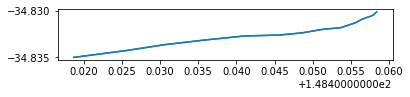

In [9]:
# Show simple plot of the model
fs.plot_paths(model_gdfs)